In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# from tensorboardX import SummaryWriter

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [24]:
fpath = "../../data/DNN_data/v1/"

sig_with_artifact = np.load(fpath + "data_signal_with_sine_regular_pattern" + ".npy")
sig = np.load(fpath + "data_signal" + ".npy")
artifact = sig_with_artifact - sig

print(sig_with_artifact.shape)
print(sig.shape)

(1000, 4000)
(1000, 4000)


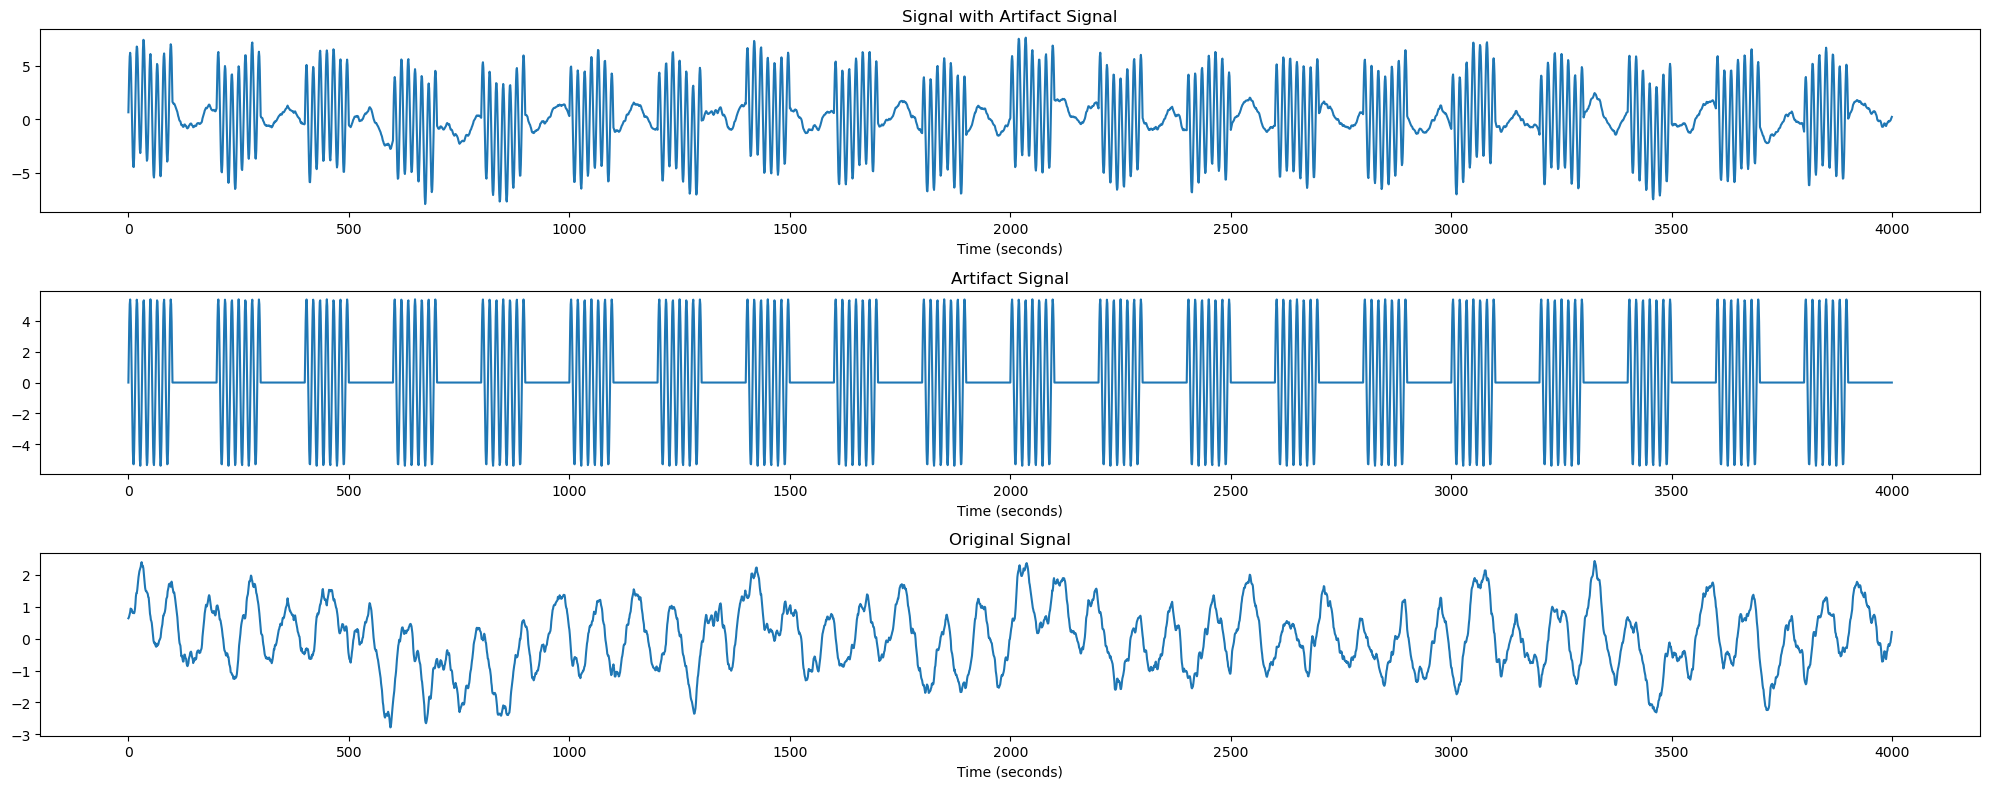

In [25]:
plt.figure(figsize=(20,8))

plt.subplot(3, 1, 1)
plt.plot(sig_with_artifact[0])
plt.xlabel("Time (seconds)")
plt.title('Signal with Artifact Signal')

plt.subplot(3, 1, 2)
plt.plot(artifact[0])
plt.xlabel("Time (seconds)")
plt.title('Artifact Signal')

plt.subplot(3, 1, 3)
plt.plot(sig[0])
plt.xlabel("Time (seconds)")
plt.title('Original Signal')

plt.tight_layout()

In [26]:
sig_with_artifact = sig_with_artifact.transpose()
sig = sig.transpose()

print(sig_with_artifact.shape)
print(sig.shape)

(4000, 1000)
(4000, 1000)


(1000, 4000)
(1000, 4000)


(-3.0, 3.0)

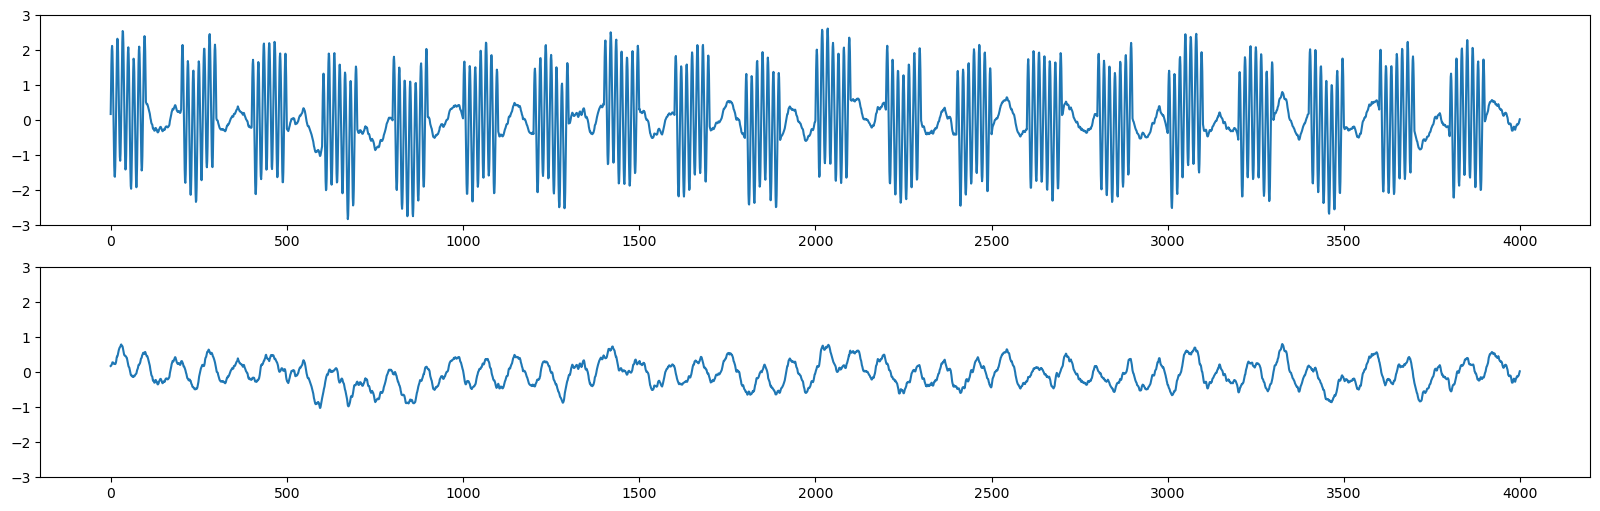

In [27]:
# StandardScaler를 이용하여 정규화
scaler = StandardScaler()
X = scaler.fit_transform(sig_with_artifact)
# y = scaler.fit_transform(sig)
y = (sig-scaler.mean_)/np.sqrt(scaler.var_) # X와 동일한 평균, 표준 편차로 scaling

X = X.transpose()
y = y.transpose()

print(X.shape)
print(y.shape)

plt.figure(figsize=(20, 6))
plt.subplot(2, 1, 1)
plt.plot(X[0])
plt.ylim([-3, 3])
plt.subplot(2, 1, 2)
plt.plot(y[0])
plt.ylim([-3, 3])

In [28]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("-----------------------------")
print("X_train shape: {}\ny_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x T, y : B x T
print("-----------------------------")
print("X_test shape: {}\ny_test shape: {}".format(X_test.shape, y_test.shape))
print("-----------------------------")

X_train = X_train.reshape(X_train.shape[0], 4000, 1)
X_test = X_test.reshape(X_test.shape[0], 4000, 1)

print("<unsqueezed>")
print("-----------------------------")
print("X_train shape: {}\ny_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x 1 x T, y : B x T
print("-----------------------------")
print("X_test shape: {}\ny_test shape: {}".format(X_test.shape, y_test.shape))
print("-----------------------------")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=50, shuffle=False)

-----------------------------
X_train shape: (800, 4000)
y_train shape: (800, 4000)
-----------------------------
X_test shape: (200, 4000)
y_test shape: (200, 4000)
-----------------------------
<unsqueezed>
-----------------------------
X_train shape: (800, 4000, 1)
y_train shape: (800, 4000)
-----------------------------
X_test shape: (200, 4000, 1)
y_test shape: (200, 4000)
-----------------------------


In [29]:
# 인코더 네트워크 생성

class Encoder(nn.Module):    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.input1 = nn.Linear(input_dim, hidden_dim)
        self.input2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)        
        self.training = True
        
    def forward(self, x):
        h_ = self.LeakyReLU(self.input1(x))
        h_ = self.LeakyReLU(self.input2(h_))
        mean = self.mean(h_)
        log_var = self.var(h_)                           
        return mean, log_var # 인코더 네트워크에서 평균과 분산을 반환

In [30]:
# 디코더 네트워크

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.hidden1 = nn.Linear(latent_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h = self.LeakyReLU(self.hidden1(x))
        h = self.LeakyReLU(self.hidden2(h))        
        # x_hat = torch.sigmoid(self.output(h)) # 디코더 결과는 시그모이드를 통과했으므로 0~1 값을 가짐
        x_hat = self.output(h)
        return x_hat 

In [31]:
# VAE 네트워크

class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var): # 평균과 표준편차를 통해 latent vector z를 샘플링
        epsilon = torch.randn_like(var).to(device)                
        z = mean + var*epsilon # z 값 구하기   
        return z
                        
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
        x_hat = self.Decoder(z)        
        return x_hat, mean, log_var, z # 디코더 결과와 평균, 표준편차를 반환

In [32]:
# 인코더와 디코더 객체 초기화

x_dim  = 4000
hidden_dim = 400
latent_dim = 40
epochs = 300
batch_size = 50

encoder_XX = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder_XX = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

encoder_Xy = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder_Xy = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model_XX = Model(Encoder=encoder_XX, Decoder=decoder_XX).to(device)
model_Xy = Model(Encoder=encoder_Xy, Decoder=decoder_Xy).to(device)

In [33]:
# 손실 함수 정의

def loss_function(x, x_hat, mean, log_var): # 오차 구하는 함수, KLD를 계산하고 KLD가 줄어드는 방향으로 q(z)를 업데이트
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum') # Loss Function을 BCE에서 MSE로 변경
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss, KLD

optimizer_XX = torch.optim.Adam(model_XX.parameters(), lr=1e-3)
optimizer_Xy = torch.optim.Adam(model_Xy.parameters(), lr=1e-3)

In [34]:
# 모델 Train 함수 정의 X -> X

# saved_loc = 'scalar/' # 텐서보드에서 사용할 경로
# import os
# import shutil
# if os.path.exists('scalar/'):
#     # 폴더가 존재하면 폴더 내의 모든 내용을 삭제
#     shutil.rmtree('scalar/')

# writer = SummaryWriter(saved_loc) # 텐서보드: 오차와 같은 주요 측정 항목들이 학습 과정에서 어떻게 변하는지 알고자 할 때 사용

model_XX.train()
def train_XX(epoch, model, train_loader, optimizer):
    train_loss = 0
    for _, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)
        optimizer.zero_grad()
        x_hat, mean, log_var, z = model(x)
        MSE, KLD = loss_function(x, x_hat, mean, log_var)
        loss = MSE + KLD
        # add_scalar: 텐서보드에 오차 등 주요 측정 항목의 결과를 출력할 때 사용
        # writer.add_scalar("Train/Reconstruction Error", BCE.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) ) 
        # writer.add_scalar("Train/KL-Divergence", KLD.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
        # writer.add_scalar("Train/Total Loss" , loss.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
        
        train_loss += loss.item()  
        loss.backward()
        optimizer.step()
          
        # if batch_idx % 100 == 0:
        #     print('Train Epoch: {}\t Loss: {:.6f}'.format(
        #         epoch, loss.item() / len(y)))
    if epoch == 0:
        print(f"Epoch: [{epoch}/{epochs}]\t\tTrain Loss: {train_loss / len(train_loader.dataset):.4f}", end='\t')
    elif epoch%10==0:        
        print(f"Epoch: [{epoch}/{epochs}]\tTrain Loss: {train_loss / len(train_loader.dataset):.4f}", end='\t')

In [35]:
# 모델 Test 함수 정의 X

def test_XX(epoch, model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(test_loader):
            x = x.view(batch_size, x_dim)
            x = x.to(device)   
            x_hat, mean, log_var, z = model(x)
            MSE, KLD = loss_function(x, x_hat, mean, log_var)
            loss = MSE + KLD

            # 테스트 데이터셋에 대해서도 오차를 로그에 저장
            # writer.add_scalar("Test/Reconstruction Error", BCE.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            # writer.add_scalar("Test/KL-Divergence", KLD.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            # writer.add_scalar("Test/Total Loss" , loss.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            test_loss += loss.item()

            # if batch_idx == 0:
            #     n = min(x.size(0), 8)
            #     comparison = torch.cat([x[:n], x_hat.view(batch_size, x_dim)[:n]])
            #     grid = torchvision.utils.make_grid(comparison.cpu()) 
            #     writer.add_image("Test image - Above: Real data, below: reconstruction data", grid, epoch)
        if epoch == 0:
            print(f"Test Loss: {test_loss / len(test_loader.dataset):.4f}")
        elif epoch%10==0:        
            print(f"Test Loss: {test_loss / len(test_loader.dataset):.4f}")

In [36]:
# 모델 Train 함수 정의 y -> y

# saved_loc = 'scalar/' # 텐서보드에서 사용할 경로
# import os
# import shutil
# if os.path.exists('scalar/'):
#     # 폴더가 존재하면 폴더 내의 모든 내용을 삭제
#     shutil.rmtree('scalar/')

# writer = SummaryWriter(saved_loc) # 텐서보드: 오차와 같은 주요 측정 항목들이 학습 과정에서 어떻게 변하는지 알고자 할 때 사용

model_Xy.train()
def train_Xy(epoch, model, train_loader, optimizer):
    train_loss = 0
    for batch_idx, (x, y) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)
        y = y.view(batch_size, x_dim)
        y = y.to(device)
        optimizer.zero_grad()
        y_hat, mean, log_var, z = model(x)
        MSE, KLD = loss_function(y, y_hat, mean, log_var)
        loss = MSE + KLD
        # add_scalar: 텐서보드에 오차 등 주요 측정 항목의 결과를 출력할 때 사용
        # writer.add_scalar("Train/Reconstruction Error", BCE.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) ) 
        # writer.add_scalar("Train/KL-Divergence", KLD.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
        # writer.add_scalar("Train/Total Loss" , loss.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
        
        train_loss += loss.item()  
        loss.backward()
        optimizer.step()
          
        # if batch_idx % 100 == 0:
        #     print('Train Epoch: {}\t Loss: {:.6f}'.format(
        #         epoch, loss.item() / len(y)))
    if epoch == 0:
        print(f"Epoch: [{epoch}/{epochs}]\t\tTrain Loss: {train_loss / len(train_loader.dataset):.4f}", end='\t')
    elif epoch%10==0:        
        print(f"Epoch: [{epoch}/{epochs}]\tTrain Loss: {train_loss / len(train_loader.dataset):.4f}", end='\t')

In [37]:
# 모델 Test 함수 정의 y

def test_Xy(epoch, model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(test_loader):
            x = x.view(batch_size, x_dim)
            x = x.to(device)
            y = y.view(batch_size, x_dim)
            y = y.to(device)   
            y_hat, mean, log_var, z = model(x)
            MSE, KLD = loss_function(y, y_hat, mean, log_var)
            loss = MSE + KLD

            # 테스트 데이터셋에 대해서도 오차를 로그에 저장
            # writer.add_scalar("Test/Reconstruction Error", BCE.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            # writer.add_scalar("Test/KL-Divergence", KLD.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            # writer.add_scalar("Test/Total Loss" , loss.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            test_loss += loss.item()

            # if batch_idx == 0:
            #     n = min(x.size(0), 8)
            #     comparison = torch.cat([x[:n], x_hat.view(batch_size, x_dim)[:n]])
            #     grid = torchvision.utils.make_grid(comparison.cpu()) 
            #     writer.add_image("Test image - Above: Real data, below: reconstruction data", grid, epoch)
        if epoch == 0:
            print(f"Test Loss: {test_loss / len(test_loader.dataset):.4f}")
        elif epoch%10==0:        
            print(f"Test Loss: {test_loss / len(test_loader.dataset):.4f}")

In [38]:
# 모델 학습 X

from tqdm.auto import tqdm
for epoch in tqdm(range(0, epochs)):
    train_XX(epoch, model_XX, train_loader, optimizer_XX)
    test_XX(epoch, model_XX, test_loader)
# writer.close()

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: [0/300]		Train Loss: 1482.5822	Test Loss: 398.0748
Epoch: [10/300]	Train Loss: 270.2310	Test Loss: 270.7823
Epoch: [20/300]	Train Loss: 261.2303	Test Loss: 260.3778
Epoch: [30/300]	Train Loss: 258.6048	Test Loss: 266.0407
Epoch: [40/300]	Train Loss: 253.9724	Test Loss: 253.8976
Epoch: [50/300]	Train Loss: 244.6606	Test Loss: 248.6688
Epoch: [60/300]	Train Loss: 234.3536	Test Loss: 243.5348
Epoch: [70/300]	Train Loss: 227.5319	Test Loss: 235.7126
Epoch: [80/300]	Train Loss: 219.2079	Test Loss: 230.7841
Epoch: [90/300]	Train Loss: 208.5790	Test Loss: 224.1488
Epoch: [100/300]	Train Loss: 198.8094	Test Loss: 217.1833
Epoch: [110/300]	Train Loss: 190.6766	Test Loss: 213.3358
Epoch: [120/300]	Train Loss: 183.9386	Test Loss: 210.5919
Epoch: [130/300]	Train Loss: 175.1142	Test Loss: 208.4824
Epoch: [140/300]	Train Loss: 167.2523	Test Loss: 207.9307
Epoch: [150/300]	Train Loss: 162.4012	Test Loss: 211.1233
Epoch: [160/300]	Train Loss: 155.5115	Test Loss: 208.7645
Epoch: [170/300]	Train 

In [39]:
# 모델 학습 y

from tqdm.auto import tqdm
for epoch in tqdm(range(0, epochs)):
    train_Xy(epoch, model_Xy, train_loader, optimizer_Xy)
    test_Xy(epoch, model_Xy, test_loader)
# writer.close()

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: [0/300]		Train Loss: 337.8405	Test Loss: 271.5567
Epoch: [10/300]	Train Loss: 246.6831	Test Loss: 248.0797
Epoch: [20/300]	Train Loss: 243.0811	Test Loss: 246.1431
Epoch: [30/300]	Train Loss: 230.8727	Test Loss: 237.4451
Epoch: [40/300]	Train Loss: 217.7759	Test Loss: 228.0020
Epoch: [50/300]	Train Loss: 200.5775	Test Loss: 220.9257
Epoch: [60/300]	Train Loss: 187.1034	Test Loss: 215.3523
Epoch: [70/300]	Train Loss: 172.3677	Test Loss: 209.5040
Epoch: [80/300]	Train Loss: 157.9809	Test Loss: 211.9948
Epoch: [90/300]	Train Loss: 147.3708	Test Loss: 213.8419
Epoch: [100/300]	Train Loss: 137.1558	Test Loss: 221.3810
Epoch: [110/300]	Train Loss: 127.9227	Test Loss: 223.7461
Epoch: [120/300]	Train Loss: 118.7823	Test Loss: 229.3665
Epoch: [130/300]	Train Loss: 112.7863	Test Loss: 232.8059
Epoch: [140/300]	Train Loss: 106.6972	Test Loss: 234.4546
Epoch: [150/300]	Train Loss: 103.7183	Test Loss: 239.0988
Epoch: [160/300]	Train Loss: 98.7490	Test Loss: 246.1551
Epoch: [170/300]	Train Lo

No handles with labels found to put in legend.


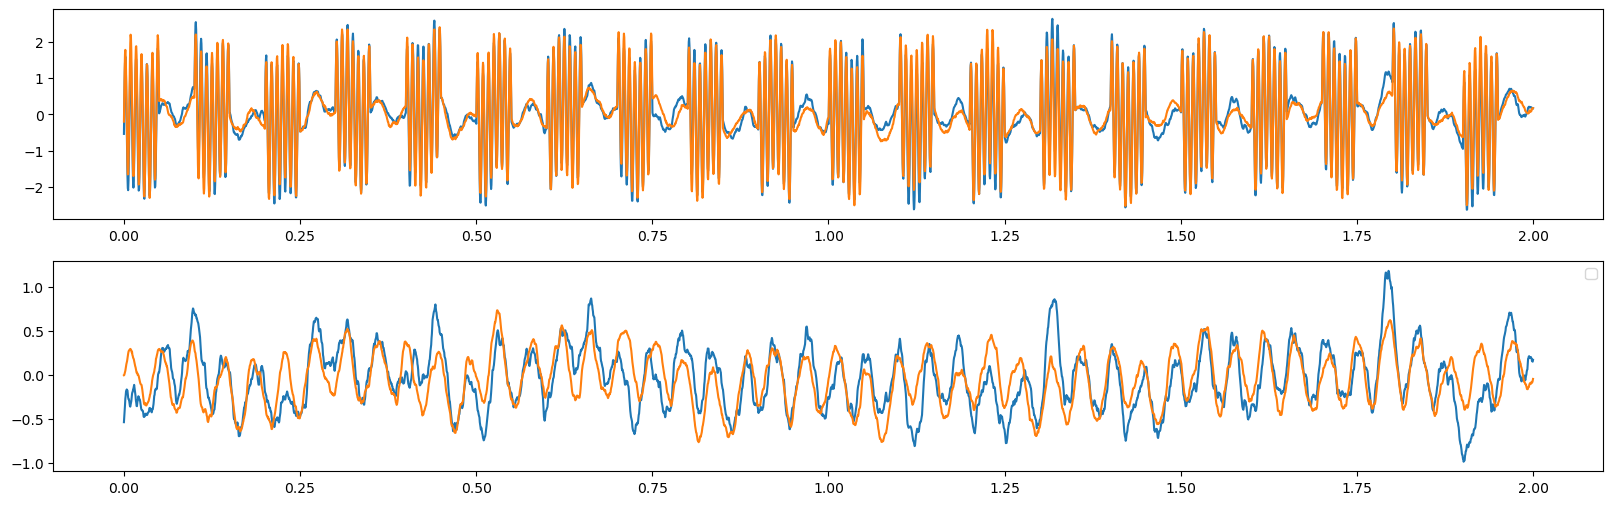

In [45]:
for _, (x, y) in enumerate(test_loader):
        x = x.view(batch_size, x_dim).to(device)
        y = y.view(batch_size, x_dim).to(device)
        break
    
model_XX.eval()
model_Xy.eval()

x_hat, _, _, _ = model_XX(x) 
y_hat, _, _, _ = model_Xy(x)

t = np.linspace(0, 2, num=4000)           

plt.figure(figsize=(20,6))

plt.subplot(2, 1, 1)
plt.plot(t, x[0])
plt.plot(t, x_hat[0].detach().numpy())

plt.subplot(2, 1, 2)
plt.plot(t, y[0])
plt.plot(t, y_hat[0].detach().numpy())

plt.legend()

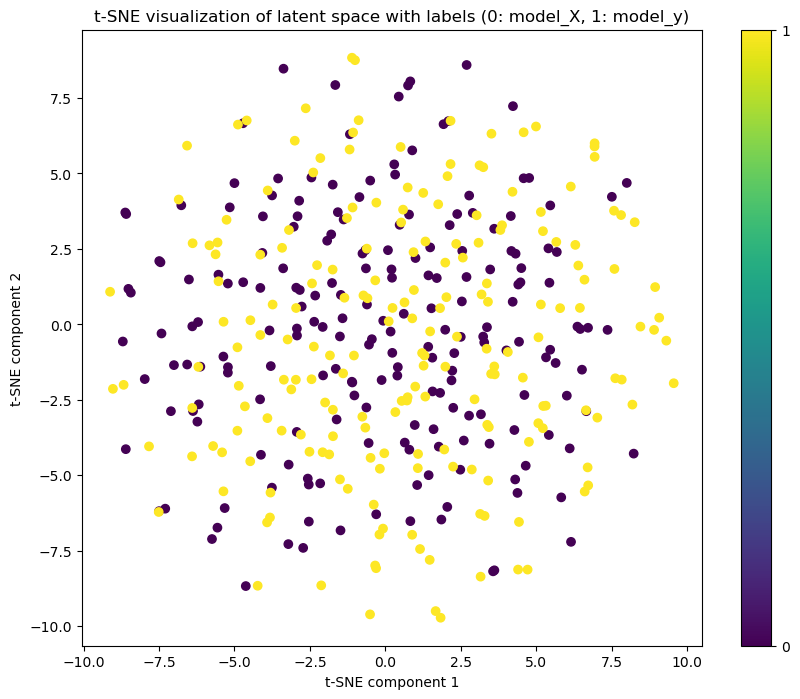

In [46]:
# latent z

from sklearn.manifold import TSNE

# 모델이 evaluation mode에서 실행되도록 설정
model_XX.eval()
model_Xy.eval()

# latent vector z와 라벨을 저장할 리스트 초기화
z_X_list = []
z_y_list = []

with torch.no_grad():
    for batch_idx, (x, y) in enumerate(test_loader):
        x = x.view(batch_size, x_dim).to(device)
        y = y.view(batch_size, x_dim).to(device)
        
        _, _, _, z_X = model_XX(x)
        _, _, _, z_y = model_Xy(x)
        
        # z와 라벨을 numpy 배열로 변환하여 리스트에 추가
        z_X_list.append(z_X.cpu().numpy())
        z_y_list.append(z_y.cpu().numpy())

# z_list와 labels_list를 단일 numpy 배열로 결합
z_X_combined = np.concatenate(z_X_list, axis=0)
z_y_combined = np.concatenate(z_y_list, axis=0)

# 두 모델의 latent vector 결합 및 라벨 생성
z_combined = np.concatenate([z_X_combined, z_y_combined], axis=0)
labels_combined = np.concatenate([np.zeros(z_X_combined.shape[0]), np.ones(z_y_combined.shape[0])])

# t-SNE를 사용하여 2차원으로 축소
z_embedded = TSNE(n_components=2).fit_transform(z_combined)

# 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_embedded[:, 0], z_embedded[:, 1], c=labels_combined, cmap='viridis')
plt.colorbar(scatter, ticks=[0, 1])
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.title("t-SNE visualization of latent space with labels (0: model_X, 1: model_y)")
plt.show()

In [42]:
# 두 클래스의 latent vector 분석
mean_z_X = np.mean(z_X_combined, axis=0)
mean_z_y = np.mean(z_y_combined, axis=0)
std_z_X = np.std(z_X_combined, axis=0)
std_z_y = np.std(z_y_combined, axis=0)

# 두 클래스 간의 차이
difference = np.abs(mean_z_X - mean_z_y)
important_dims = np.argsort(difference)[-5:]  # 가장 큰 차이를 보이는 상위 5개 차원 선택
print("Important dimensions:", important_dims)

Important dimensions: [ 6 18 24 13 31]


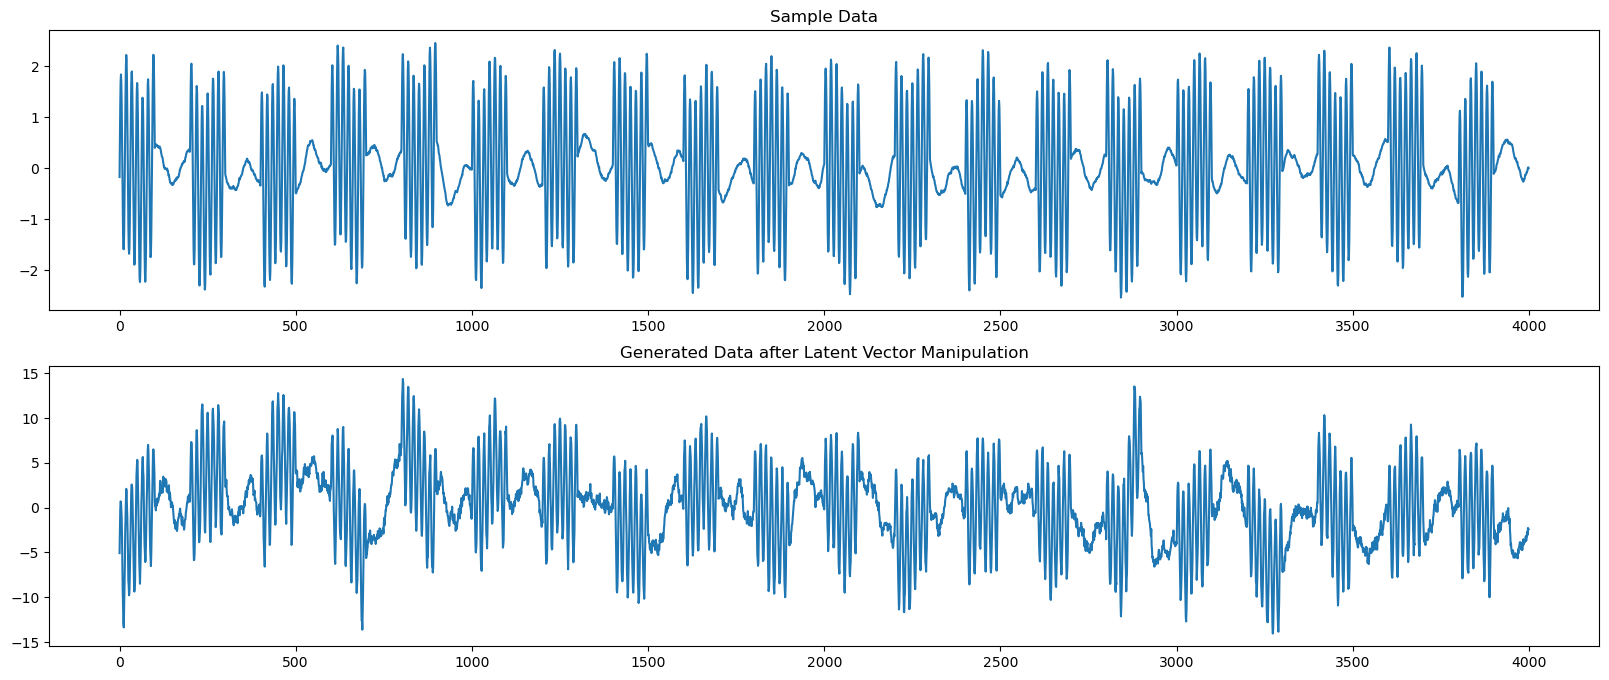

In [43]:
# 임의의 latent vector 선택 (예: X에서 선택)
z_X_sample = z_X_combined[0]

z_sample_tensor = torch.tensor(z_X_sample).to(device).float().unsqueeze(0)
with torch.no_grad():
    sample_data = model_XX.Decoder(z_sample_tensor).cpu().numpy()
    
# 중요한 차원의 값을 조작
z_X_modified = z_X_sample.copy()
for dim in important_dims:
    z_X_modified[dim] += (mean_z_y[dim] - mean_z_X[dim])  # y 방향으로 이동

# 조작된 latent vector를 통해 데이터 생성
z_X_modified_tensor = torch.tensor(z_X_modified).to(device).float().unsqueeze(0)
with torch.no_grad():
    generated_data = model_XX.Decoder(z_X_modified_tensor).cpu().numpy()

# 생성된 데이터 확인 (예: 시각화)
plt.figure(figsize=(20, 8))
plt.subplot(2, 1, 1)
plt.plot(sample_data[0])
plt.title("Sample Data")
plt.subplot(2, 1, 2)
plt.plot(generated_data[0])
plt.title("Generated Data after Latent Vector Manipulation")
plt.show()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

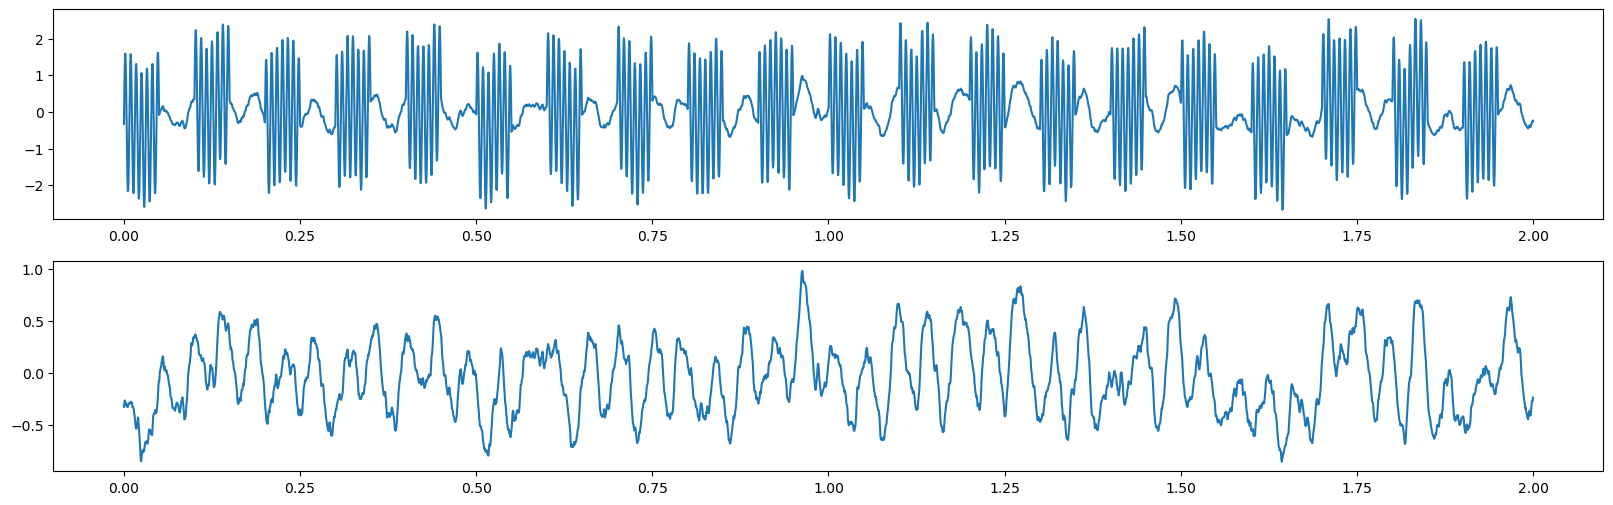

In [44]:
x = x.cpu()
x_hat = x_hat.cpu()

t = np.linspace(0, 2, num=4000)           

plt.figure(figsize=(20,6))

plt.subplot(2, 1, 1)
plt.plot(t, x[0])

plt.subplot(2, 1, 2)
plt.plot(t, y[0], label='Actual')
plt.plot(t, x_hat[0], label='Predicted')
plt.legend()

In [ ]:
# 텐서보드에서 오차 확인

# %load_ext tensorboard # magic command
# %tensorboard --logdir scalar --port=6013

In [ ]:
# time domain plotting

predicted_signal = x_hat[0]
actual_signal = y[0]

t = np.linspace(0, 2, num=4000)  

plt.figure(figsize=(20, 3))
plt.plot(t, actual_signal, label='Actual Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.plot(t, predicted_signal, label='Predicted Signal', color='orange', alpha=1, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('Predicted vs Actual Signal')
plt.legend()
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(actual_signal, predicted_signal)}")
print(f"Mean Squared Error: {mean_squared_error(actual_signal, predicted_signal)}")

In [ ]:
# frequency domain plotting

n = len(predicted_signal)

fs = 2000
freqs = np.fft.fftfreq(n, d=1/fs)[:n//2]

fft_predicted = np.fft.fft(predicted_signal)
fft_predicted = np.abs(fft_predicted[:n//2])
fft_predicted[1:] = 2 * fft_predicted[1:]
power_predicted = fft_predicted**2

fft_actual = np.fft.fft(actual_signal)
fft_actual = np.abs(fft_actual[:n//2])
fft_actual[1:] = 2 * fft_actual[1:]
power_actual = fft_actual**2

# 결과 플로팅
plt.figure(figsize=(10, 6))
plt.plot(freqs, np.log10(power_actual), label='Actual Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.plot(freqs, np.log10(power_predicted), label='Predicted Signal', color='red', alpha=1, linewidth=0.7)
plt.title('Power Spectrum of Predicted and Actual Signals')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(np.log10(power_predicted), np.log10(power_actual))}")
print(f"Mean Squared Error: {mean_squared_error(np.log10(power_predicted), np.log10(power_actual))}")